## Task 2

### Question
Implement a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability.

Requirements :

-The circuit should consist only of CNOTs, RXs and RYs.

-Start from all parameters in parametric gates being equal to 0 or randomly chosen. 

-You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 

-Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

#### Bonus question:
How to make sure you produce state $|01\rangle$ + $|10\rangle$ and not $|01\rangle$ - $|10\rangle$ ?


### Solution

As a part of QOSF screening tasks I am attempting the above question with Pennylane with qiskit plugin. 

* I used pennylane because it provides an easy way to define circuits with parameters as well as wide range of optimizers to optimize the circuit with.

* I am using qiskit pugin to import the noise model

Import the required libraries

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.providers.aer.noise import NoiseModel

Import the noise model

In [2]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_vigo')
noise_model = NoiseModel.from_backend(backend)

/home/rochisha/anaconda3/envs/quantum/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


We need the state $\tfrac{1}{\sqrt{2}}(|01\rangle + |10\rangle)$. Essentially this state is a Bell's State that can be developed by applying creating a superposition through Hadamard Gate.

$$|0\rangle \otimes |1\rangle \rightarrow \tfrac{1}{\sqrt{2}}(|0\rangle + |1\rangle)  \otimes |1\rangle$$
$$|1\rangle \otimes |1\rangle \rightarrow \tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)  \otimes |1\rangle$$

Then apply a CNOT gate which gives,
$$\tfrac{1}{\sqrt{2}}(|0\rangle + |1\rangle)  \otimes |1\rangle \rightarrow \tfrac{1}{\sqrt{2}}(|01\rangle + |10\rangle)$$
$$\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)  \otimes |1\rangle \rightarrow \tfrac{1}{\sqrt{2}}(|01\rangle - |10\rangle)$$

But for the sake of the task we have to use Rx and Ry gates and find the parameters through optimization.

#### Creating the circuit with H and X and CNOT

In [3]:
number_qubits = 2

dev1 = qml.device("qiskit.aer", wires=number_qubits, shots=1000, noise_model = noise_model, analytic=False)
#initialized the device with analytics= False because we will change the no. of shots for sampling

@qml.qnode(dev1)
def psi():
    
    qml.Hadamard(wires=0)
    
    qml.PauliX(wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    #Return probablity of states in lexigrophical ordering '00', '01', '10', '11'
    return qml.probs(wires=[0,1]) 

psi()

array([0.029, 0.458, 0.506, 0.007])

#### Creating the circuit with parametrized Rx, Ry (we take two parameters). I don't add RX gate on the qubits because it adds a phase of $-i$. 

In [4]:
def circ(theta):
    qml.RY(theta[0], wires=0)
    
    qml.RY(theta[1], wires=1)
    
    qml.CNOT(wires=[0, 1])

#### Intitalizing the circuit with noise

In [5]:
number_qubits = 2

dev = qml.device("qiskit.aer", wires=number_qubits, shots=1000, noise_model = noise_model, analytic=False)

@qml.qnode(dev)
def bell_state(theta):
    
    circ(theta)
    
    return qml.probs(wires=[0,1])


#### Without noise

In [6]:
number_qubits = 2

dev_noiseless = qml.device("qiskit.aer", wires=number_qubits, shots=1000, analytic=False)

@qml.qnode(dev_noiseless)
def bell_state_noiseless(theta):
    
    circ(theta)
    
    return qml.probs(wires=[0,1])

`qml.probs()` will return a flat array or tensor containing the (marginal) probabilities of each quantum state in the lexigrophic ordering. 

Hence first value of the array corresponds to probability of state '00', second '01', third '10' and fourth '11'

We have to get the probablity of state,
$$00 \rightarrow 0 $$
$$01 \rightarrow 0.5 $$
$$10 \rightarrow 0.5 $$
$$11 \rightarrow 0 $$

We have to minimize,
 `((prob_00-0)**2 + (prob_01-0.5)**2 + (prob_10-0.5)**2 + (prob_11-0)**2)`

In [7]:
def cost(theta):
    prob_00, prob_01, prob_10, prob_11 = bell_state(theta)
    return ((prob_00-0)**2 + (prob_01-0.5)**2 + (prob_10-0.5)**2 + (prob_11-0)**2)

In [8]:
def cost_noiseless(theta):
    prob_00, prob_01, prob_10, prob_11 = bell_state_noiseless(theta)
    return ((prob_00-0)**2 + (prob_01-0.5)**2 + (prob_10-0.5)**2 + (prob_11-0)**2)

Now we have to find the parameters by the Gradient Descent Optimizer (given in the library) and minimize the cost.

In [9]:
prob = []
all_costs = []

for num_shots in [1, 10, 100, 1000]:
    dev.shots = num_shots
    initial_parameters = np.random.randn(2) #starting with random parameters
    
    steps = 40 # Number of steps of optimization
    
    parameters = initial_parameters.copy()
    
    optimizer = qml.GradientDescentOptimizer(stepsize=0.6) #The Gradient Descent Optimizer
    
    costs = []
    
    print('--------------------------------\n')
    print('For {0} shots\n'.format(num_shots))
    for i in range(steps):
        costs.append(cost(parameters))
        parameters = optimizer.step(cost, parameters)
        
        if (i%10 == 0):
            print('The cost for {0} measurement sampling is {1}\n'.format(num_shots, cost(parameters)))
            print('The parameters are {0}\n'.format(parameters))
    all_costs.append(costs)

    p = [0, 0, 0, 0]
    p[0], p[1], p[2], p[3] = bell_state(parameters)
    print('Final probability of states is as follows: \n')
    print('\n Probality of 00 is: {0} \n Probality of 01 is: {1} \n Probality of 10 is: {2} \n Probality of 11 is: {3}'.format(p[0], p[1], p[2], p[3]))
    prob.append(p)

--------------------------------

For 1 shots

The cost for 1 measurement sampling is 0.5

The parameters are [1.08937707 2.18902302]

The cost for 1 measurement sampling is 0.5

The parameters are [2.58937707 3.08902302]

The cost for 1 measurement sampling is 0.5

The parameters are [4.38937707 4.58902302]

The cost for 1 measurement sampling is 0.5

The parameters are [4.38937707 4.58902302]

Final probability of states is as follows: 


 Probality of 00 is: 0.0 
 Probality of 01 is: 0.0 
 Probality of 10 is: 1.0 
 Probality of 11 is: 0.0
--------------------------------

For 10 shots

The cost for 10 measurement sampling is 0.36

The parameters are [-1.2590557  -1.30969399]

The cost for 10 measurement sampling is 0.12

The parameters are [-1.6970557  -2.45569399]

The cost for 10 measurement sampling is 0.060000000000000005

The parameters are [-1.7690557  -2.78569399]

The cost for 10 measurement sampling is 0.07999999999999999

The parameters are [-1.3790557  -2.80969399]

Final

In [10]:
print('We get the final parameters as {0} for RY and RX respectively with noisy simulations.'.format(parameters))

We get the final parameters as [-1.57536811  2.94342436] for RY and RX respectively with noisy simulations.


### Probability Distribution

<BarContainer object of 4 artists>

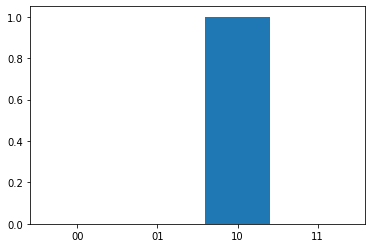

In [11]:
plt.bar(['00','01','10', '11'], prob[0]) #Probability Distribution for shots 1

<BarContainer object of 4 artists>

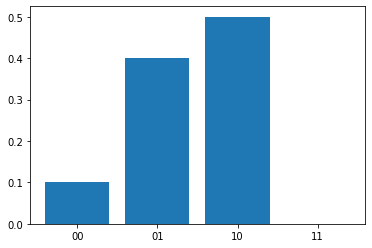

In [12]:
plt.bar(['00','01','10', '11'], prob[1]) #Probability Distribution for shots 10

<BarContainer object of 4 artists>

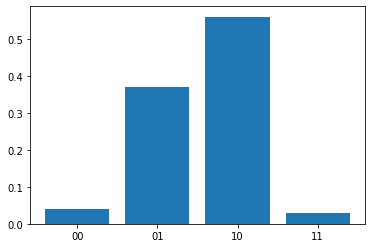

In [13]:
plt.bar(['00','01','10', '11'], prob[2])  #Probability Distribution for shots 100

<BarContainer object of 4 artists>

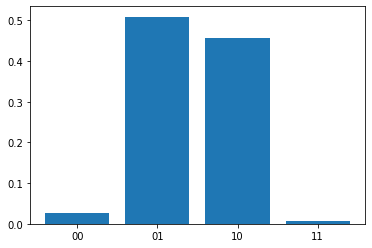

In [14]:
plt.bar(['00','01','10', '11'], prob[3])   #Probability Distribution for shots 1000

### Evolution of cost

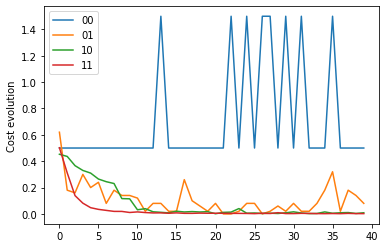

In [15]:
plt.plot(all_costs[0], label ="00")
plt.plot(all_costs[1], label ="01")
plt.plot(all_costs[2], label ="10")
plt.plot(all_costs[3], label ="11")
plt.ylabel('Cost evolution')
plt.legend()
plt.show()

#### Noiseless Simulation

In [16]:
prob = []
all_costs = []

for num_shots in [1000]:
    dev_noiseless.shots = num_shots
    initial_parameters = np.random.randn(2) #starting with random parameters
    
    steps = 40 # Number of steps of optimization
    
    parameters = initial_parameters.copy()
    
    optimizer = qml.GradientDescentOptimizer(stepsize=0.6) #The Gradient Descent Optimizer
    
    costs = []
    
    print('--------------------------------\n')
    print('For {0} shots\n'.format(num_shots))
    for i in range(steps):
        costs.append(cost_noiseless(parameters))
        parameters = optimizer.step(cost_noiseless, parameters)
        
        if (i%10 == 0):
            print('The cost for {0} measurement sampling is {1}\n'.format(num_shots, cost(parameters)))
            print('The parameters are {0}\n'.format(parameters))
    all_costs.append(costs)

    p = [0, 0, 0, 0]
    p[0], p[1], p[2], p[3] = bell_state_noiseless(parameters)
    print('Final probability of states is as follows: \n')
    print('\n Probality of 00 is: {0} \n Probality of 01 is: {1} \n Probality of 10 is: {2} \n Probality of 11 is: {3}'.format(p[0], p[1], p[2], p[3]))
    prob.append(p)

--------------------------------

For 1000 shots

The cost for 1000 measurement sampling is 0.16755400000000004

The parameters are [ 1.54840813 -1.82400221]

The cost for 1000 measurement sampling is 0.010693999999999999

The parameters are [ 1.55288293 -2.60598161]

The cost for 1000 measurement sampling is 0.0056119999999999955

The parameters are [ 1.57065493 -2.75064041]

The cost for 1000 measurement sampling is 0.007710000000000001

The parameters are [ 1.56250153 -2.81560121]

Final probability of states is as follows: 


 Probality of 00 is: 0.012 
 Probality of 01 is: 0.507 
 Probality of 10 is: 0.473 
 Probality of 11 is: 0.008


<BarContainer object of 4 artists>

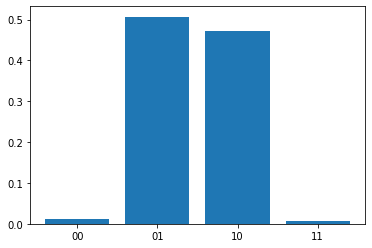

In [17]:
plt.bar(['00','01','10', '11'], prob[0])   #Probability Distribution for shots 1000

#### Conclusion

We clearly see through this output that cost reduces significantly with the increase in shots, and we also get a precise probability through that. Noiseless simulation, as expected, increase the precision.

### Bonus

How do we prepare $|01\rangle + |10\rangle$ and not $|01\rangle - |10\rangle$?

#### Solution

First we define the same circuit but find the expectation value of X $\otimes$ X operator. The value $|01\rangle + |10\rangle$ is +1 and $|01\rangle - |10\rangle$ is -1, as shown below,

In [18]:
number_qubits = 2

dev1 = qml.device("default.qubit", wires=number_qubits, shots=1000, analytic=False)
#initialized the device with analytics= False because we will change the no. of shots for sampling

@qml.qnode(dev1)
def c_plus():
    
    qml.Hadamard(wires=0)

    qml.PauliX(wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliX(0)@(qml.PauliX(1)))
c_plus()

1.0

In [19]:
number_qubits = 2

dev1 = qml.device("default.qubit", wires=number_qubits, shots=1000, analytic=False)
#initialized the device with analytics= False because we will change the no. of shots for sampling

@qml.qnode(dev1)
def c_minus():
    qml.PauliX(wires=0)
    qml.Hadamard(wires=0)

    qml.PauliX(wires=1)
    qml.CNOT(wires=[0, 1])
    return qml.expval(qml.PauliX(0)@(qml.PauliX(1)))
c_minus()

-1.0

#### Parametrized circuit 

We redefine the circuit because we expect the parametric value for RY gate to $\tfrac{\pi}{2}$ and RX to be $\pi$. Hence we give RY gate the parameter values theta and RZ gate 2*theta

In [20]:
number_qubits = 2

dev = qml.device("default.qubit", wires=number_qubits, shots=1000, analytic=False)

@qml.qnode(dev)
def qc(theta):
    qml.RY(theta[0], wires=0)
    
    qml.RY(theta[0]*2, wires=1)
    
    qml.CNOT(wires=[0, 1])
    
    return qml.expval(qml.PauliX(0) @ qml.PauliX(1))

Now we redefine the cost function,

In [21]:
def cost(theta):
    val = qc(theta)
    return -1*val

In [22]:
num_shots = 1000
dev.shots = num_shots
initial_parameters = np.random.randn(1) #starting with random parameters
    
steps = 100 # Number of steps of optimization
    
parameters = initial_parameters.copy()
    
optimizer = qml.GradientDescentOptimizer(stepsize=0.6) #The Gradient Descent Optimizer
    
costs = []
    
for i in range(steps):
    costs.append(cost(parameters))
    parameters = optimizer.step(cost, parameters)

print('\nThe final parameters for {0} measurement sampling are: {1}'.format(num_shots, parameters))
val = qc(parameters)
print('The expectation value is: {0}'.format(val))


The final parameters for 1000 measurement sampling are: [1.5882993]
The expectation value is: 1.0
